## Evaluation of the different MobileNetV3 versions

In [2]:
import os
import sys
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if root_dir not in sys.path:
    sys.path.append(root_dir)

from DatasetLoader import DatasetLoader as dl
from yaml_reader import yaml_reader

#### 1. Load the trained models

In [3]:
models = []
names = []

for model in os.listdir("out"):
    print(model)
    models.append(tf.keras.models.load_model(f"out/{model}", compile=True))
    names.append(model)

v3_d256_128_r128.keras
v3_d256_128_r224.keras
v3_d256_128_r96.keras
v3_d512_256_r128.keras
v3_d512_256_r224.keras
v3_d512_256_r96.keras


#### 2. load in the validation dataset.


In [ ]:
#there are three datasets needed: 96, 128, 256
dl_loaders =[]
datasets = []
ds = []

for i in [96, 128, 224]:
    dl_loaders.append(dl("RGB", "count", i))
    dataset, c = dl_loaders[-1].create_dataset_count("validate")
    datasets.append(dataset)
    ds.append((datasets[-1]         
            .map(lambda f, c: dl_loaders[-1].get_sample(f, c, train=False), 
                 num_parallel_calls=tf.data.AUTOTUNE)
            .batch(35)                          
            .prefetch(tf.data.AUTOTUNE)))

#### 3. Test the models performance

In [6]:
model_to_ds = {"r96": ds[0],
               "r128": ds[1],
               "r224": ds[2]}

out = dict()

for i in range(len(names)):
    for key in model_to_ds:
        if key in names[i]:
            out[names[i].replace(".keras", "")] = models[i].evaluate(model_to_ds[key])


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 682ms/step - loss: 2.5137 - mae: 2.5137
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - loss: 1.7171 - mae: 1.7171
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 1.8073 - mae: 1.8073
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - loss: 1.7697 - mae: 1.7697
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - loss: 4.5188 - mae: 4.5188
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - loss: 1.7984 - mae: 1.7984


[3.08840203 2.77215123 2.79144239 2.81913042 3.78117585 2.83894753]
['v3_d256_128_r128', 'v3_d256_128_r224', 'v3_d256_128_r96', 'v3_d512_256_r128', 'v3_d512_256_r224', 'v3_d512_256_r96']


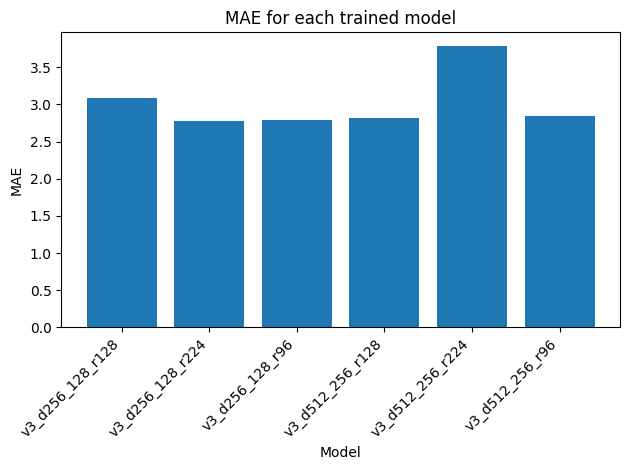

In [7]:
keys = list(out.keys())
values = list(out.values())
loss = np.zeros(6)
mae = np.zeros(6)
for i in range(len(values)):
    loss[i], mae[i] = values[i]

print(loss)
print(keys)

# Create a bar plot
plt.bar(keys, mae)
plt.xlabel('Model')
plt.ylabel('MAE')
plt.title('MAE for each trained model')
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()
plt.show()

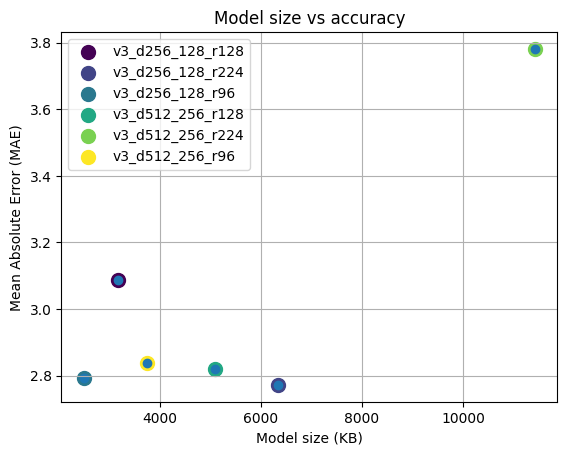

In [8]:
#Show the accuracy in relation with the size of the model:

yaml = yaml_reader("model_info.yaml")

size = []

for i in keys:
    size.append(yaml[i]["size"]["kilobytes"])

colors = plt.cm.viridis(np.linspace(0, 1, len(keys)))

for size1, mae1, color1, label1 in zip(size, mae, colors, keys):
    plt.scatter(size1, mae1, color=color1, label=label1, s=100)

plt.scatter(size, mae)
plt.xlabel('Model size (KB)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Model size vs accuracy')
plt.legend()
plt.grid(True)
plt.show()

#### Convert en quantizise to tflite

only the smallest model: 96, a=0.35

In [9]:
def to_cpp(tflite_model, tflite_filename, define_name):
    cpp_filename = tflite_filename.replace('.tflite', '.cpp')
    with open(cpp_filename, "w") as f:
        var_name = tflite_filename.replace(".", "_")  # Generate a variable name from the file
        f.write('#include "model.h"\n\n')
        f.write(f'#ifdef {define_name}\n\n')
        f.write("const unsigned char model_data[] = {")

        for i, b in enumerate(tflite_model):
            if i % 12 == 0:  # Break line every 12 bytes like xxd
                f.write("\n    ")
            f.write(f"0x{b:02x}, ")

        f.write("\n};\n")
        f.write(f"const unsigned int model_data_len = {len(tflite_model)};\n")
        f.write(f"#endif    //{define_name}\n")

In [10]:
def representative_dataset():
  for data in ds[0]:
    yield {
      "input_layer_3": data[0]
    }
tf_model = tf.keras.models.load_model("out/v3_d256_128_r96.keras", compile=True)
# tf_model.summary()

#converion for fully int8 quantifier
converter = tf.lite.TFLiteConverter.from_keras_model(tf_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_quant_model = converter.convert()

tflite_filename = 'tflite_models/mobilenet_small_r96.tflite'
with open(tflite_filename, 'wb') as f:
    f.write(tflite_quant_model)

to_cpp(tflite_quant_model, tflite_filename, "MOBILENET_SMALL_R96_INT8")

INFO:tensorflow:Assets written to: C:\Users\XANDER~1\AppData\Local\Temp\tmpne99ro6r\assets


INFO:tensorflow:Assets written to: C:\Users\XANDER~1\AppData\Local\Temp\tmpne99ro6r\assets


Saved artifact at 'C:\Users\XANDER~1\AppData\Local\Temp\tmpne99ro6r'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2192624726864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2192624728208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2192624728592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2192624728400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2192624727056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2192624726672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2192629793040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2192629793808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2192624729360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2192624727440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  219

c:\Users\Xander Verberckt\Documents\MP-Person-counting-on-low-cost-HW\.venv\Lib\site-packages\tensorflow\lite\python\convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
c:\Users\Xander Verberckt\Documents\MP-Person-counting-on-low-cost-HW\.venv\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [11]:
def representative_dataset():
  for data in ds[0]:
    yield {
      "input_layer_3": data[0]
    }
tf_model = tf.keras.models.load_model("out/v3_d256_128_r96.keras", compile=True)
# tf_model.summary()

#converion for fully int8 quantifier
converter = tf.lite.TFLiteConverter.from_keras_model(tf_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter._experimental_disable_per_channel_quantization_for_dense_layers = True
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_quant_model = converter.convert()

tflite_filename = 'tflite_models/mobilenet_small_r96_d.tflite'
with open(tflite_filename, 'wb') as f:
    f.write(tflite_quant_model)

to_cpp(tflite_quant_model, tflite_filename, "MOBILENET_SMALL_R96_D_INT8")

INFO:tensorflow:Assets written to: C:\Users\XANDER~1\AppData\Local\Temp\tmpwgc99y8k\assets


INFO:tensorflow:Assets written to: C:\Users\XANDER~1\AppData\Local\Temp\tmpwgc99y8k\assets


Saved artifact at 'C:\Users\XANDER~1\AppData\Local\Temp\tmpwgc99y8k'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2193337072528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2193337070800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2193337070992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2193337070416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2193337072336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2193337072720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2193337069072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2193337068688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2193337068880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2193337065232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  219

c:\Users\Xander Verberckt\Documents\MP-Person-counting-on-low-cost-HW\.venv\Lib\site-packages\tensorflow\lite\python\convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
c:\Users\Xander Verberckt\Documents\MP-Person-counting-on-low-cost-HW\.venv\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


### Calculate the MAE for quantizised model

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

def evaluate_mae(model_path, image_paths, count_csv_path, res, get_sample_fn, threshold=0.5):
    # Load ground truth counts
    gt_df = pd.read_csv(count_csv_path)
    gt_dict = dict(zip(gt_df['filename'], gt_df['count']))

    abs_errors = []

    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    for img_path in image_paths:
        filename = os.path.basename(img_path)
        gt_count = gt_dict.get(filename, None)

        if gt_count is None:
            print(f"Warning: No ground truth for {filename}")
            continue

        # Preprocess image
        image_tensor = get_sample_fn(img_path, res)
        input_scale, input_zero_point = input_details[0]['quantization']
        image_tensor_quantized = (image_tensor / input_scale + input_zero_point).astype(np.int8)

        # Model prediction
        interpreter.set_tensor(input_details[0]['index'], image_tensor_quantized)

        interpreter.invoke()

        preds_q = interpreter.get_tensor(output_details[0]['index'])

        output_scale, output_zero_point = output_details[0]['quantization']
        preds = (preds_q.astype(np.float32) - output_zero_point) * output_scale

        abs_errors.append(abs(gt_count - preds))

    mae = np.mean(abs_errors)
    print(f"MAE: {mae:.4f}")
    return mae

In [2]:
def get_sample(path, res):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)

    image = tf.image.resize(image, (res, res))
    image = tf.cast(image, tf.float32) / 255.0

    image = tf.expand_dims(image, axis=0)

    return image.numpy()

In [ ]:
import os
import re

outputs = dict()

tflites = []

for i in os.listdir("tflite_models"):
    if ".tflite" in i:
        tflites.append(f"tflite_models/{i}")

IMG_PATH = "../../dataset/hc/val/images"
CSV_PATH = "../../dataset/hc/val/count.csv"

for i in tflites:
    print(i)
    res = int(re.search("_r\d*", i).group(0).replace("_r", ""))

    image_paths = list(map(lambda x: os.path.join(IMG_PATH, x), os.listdir(IMG_PATH)))
    mae = evaluate_mae(i, image_paths, CSV_PATH, res=res, get_sample_fn=get_sample, threshold=0.5)

    outputs[i] = mae

<>:17: SyntaxWarning: invalid escape sequence '\d'
<>:17: SyntaxWarning: invalid escape sequence '\d'
C:\Users\xande\AppData\Local\Temp\ipykernel_204\539378232.py:17: SyntaxWarning: invalid escape sequence '\d'
  res = int(re.search("_r\d*", i).group(0).replace("_r", ""))
c:\Users\xande\Documents\kuleuven\MP\MP-person-counting\MP-Person-counting-on-low-cost-HW\.venv\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


tflite_models/mobilenet_small_r96.tflite
MAE: 2.7626
tflite_models/mobilenet_small_r96_d.tflite


c:\Users\xande\Documents\kuleuven\MP\MP-person-counting\MP-Person-counting-on-low-cost-HW\.venv\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


MAE: 2.7619


In [4]:
outputs

{'tflite_models/mobilenet_small_r96.tflite': np.float32(2.7626235),
 'tflite_models/mobilenet_small_r96_d.tflite': np.float32(2.761881)}